<a href="https://www.kaggle.com/code/utkarshx27/co2-emissions-eda?scriptVersionId=138752477" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="padding: 40px;color:white;margin:10;font-size:90%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://cms.bbcearth.com/sites/default/files/2020-09/Rectangle%209.jpg)"><b><span style='color:white'>CO2 Emissions: EDA and Prediction</span></b> </div>
***

<div style="width:100%;text-align:center"> 
<img align=middle src = "https://www.innovationnewsnetwork.com/wp-content/uploads/2022/11/%C2%A9-iStockPetmal-1340519929-800x450.jpg" width="700px">
</div>

# Overview:

The challenge involves predicting carbon emissions using open-source emissions data obtained from Sentinel-5P satellite observations. The dataset consists of approximately 497 unique locations in Rwanda, with observations spanning from January 2019 to November 2022. The data is split into training and test sets, with the training data containing observations from 2019 to 2021, and the goal is to predict the CO2 emissions data for the year 2022 through November.

The dataset contains seven main features obtained weekly from Sentinel-5P observations. These features are:

1. Sulphur Dioxide (SO2): It includes sub-features such as column_number_density, which represents the vertical column density at ground level, calculated using the DOAS technique.

2. Carbon Monoxide (CO): Similar to SO2, it includes sub-features like column_number_density.

3. Nitrogen Dioxide (NO2): It also includes sub-features such as column_number_density.

4. Formaldehyde (HCHO): Contains sub-features like column_number_density.

5. UV Aerosol Index (AER_AI): Represents the UV aerosol index at the observed locations.

6. Ozone (O3): Includes sub-features such as column_number_density.

7. Cloud (CLOUD): Represents cloud data at the observed locations.

The task is to build machine learning models that use this satellite observations data to predict the CO2 emissions data for the year 2022 through November. The time information and the various features provided are used to make these predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import folium
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
train = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv').drop('ID_LAT_LON_YEAR_WEEK', axis =1)
test = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv').drop('ID_LAT_LON_YEAR_WEEK', axis =1)
sub = pd.read_csv('/kaggle/input/playground-series-s3e20/sample_submission.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data pre-processing

In [2]:
data = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv').drop('ID_LAT_LON_YEAR_WEEK', axis =1)

data['date'] = pd.to_datetime(data['year'].astype(str) + '-W' + data['week_no'].astype(str) + '-1', format='%Y-W%W-%w')
data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data.set_index('date', inplace=True)

data = data.groupby(data.index).mean()

season_mapping = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}


data['season'] = data['month'].map(season_mapping)

# CO2 Emission over time:

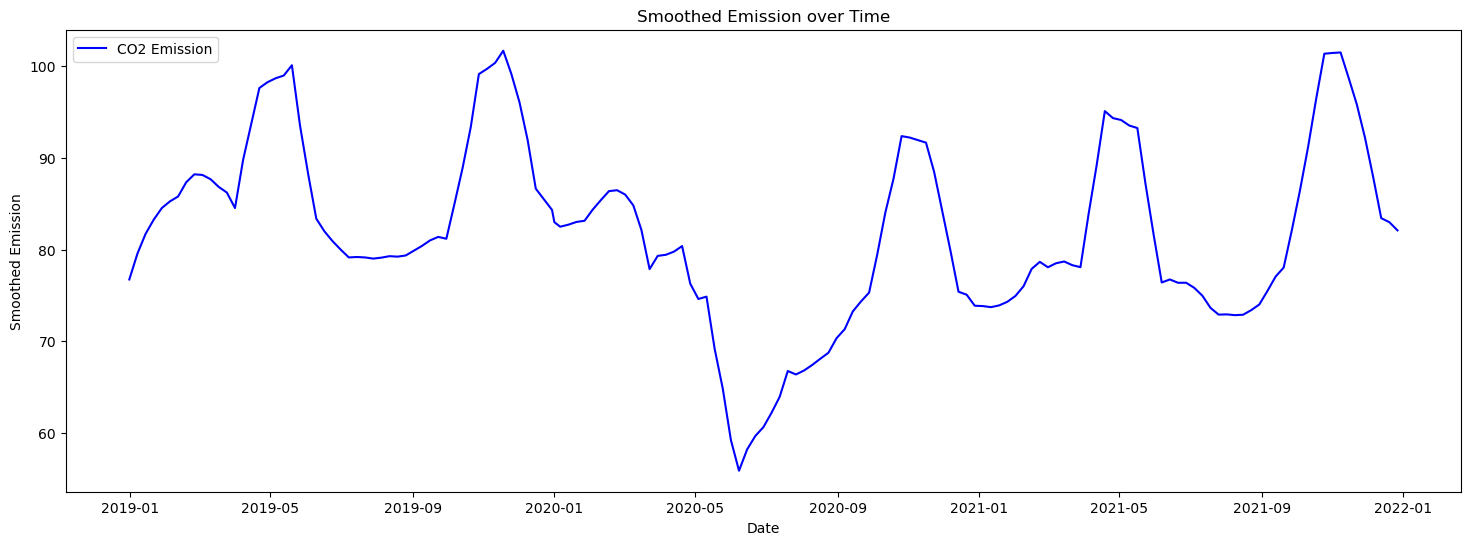

In [3]:
window_size = 7
data['emission_smoothed'] = data['emission'].rolling(window=window_size, min_periods=1).mean()
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(data.index, data['emission_smoothed'], color='blue', label='CO2 Emission')
ax.legend()
ax.set_title('Smoothed Emission over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Smoothed Emission')

plt.show()

# Emission over Time with Seasons:

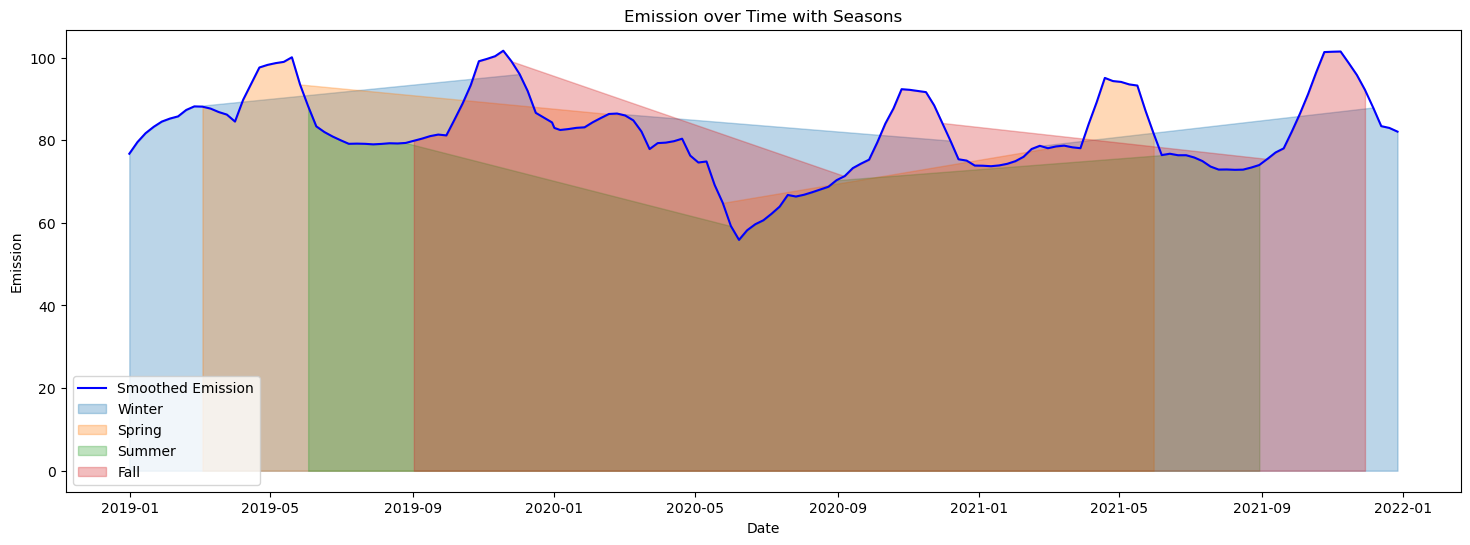

In [4]:
window_size = 7
data['emission_smoothed'] = data['emission'].rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(18, 6))

seasons = data['season'].unique()

ax.plot(data.index, data['emission_smoothed'], color='blue', label='Smoothed Emission')

for i, season in enumerate(seasons):
    season_data = data[data['season'] == season]
    ax.fill_between(season_data.index, season_data['emission_smoothed'], color=f'C{i}', alpha=0.3, label=season)

ax.legend()
ax.set_title('Emission over Time with Seasons')
ax.set_xlabel('Date')
ax.set_ylabel('Emission')
plt.show()

# Data Statistical Overview:

In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values
    summ['missing[%]'] = df.isnull().sum().values / len(df) * 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['median'] = df.median().values
    summ['std'] = df.std().values

    numeric_columns = df.select_dtypes(include=np.number).columns
    for col in numeric_columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        summ.loc[col, 'outliers'] = outliers.count()
        summ.loc[col, 'lower_bound'] = lower_bound
        summ.loc[col, 'upper_bound'] = upper_bound

    return summ

summary(train)

data shape: (79023, 75)


data type  missing  missing[%]  \
latitude                                   float64        0    0.000000   
longitude                                  float64        0    0.000000   
year                                         int64        0    0.000000   
week_no                                      int64        0    0.000000   
SulphurDioxide_SO2_column_number_density   float64    14609   18.487023   
...                                            ...      ...         ...   
Cloud_sensor_azimuth_angle                 float64      484    0.612480   
Cloud_sensor_zenith_angle                  float64      484    0.612480   
Cloud_solar_azimuth_angle                  float64      484    0.612480   
Cloud_solar_zenith_angle                   float64      484    0.612480   
emission                                   float64        0    0.000000   

                                          unique          min          max  \
latitude                                     452    -3.299000    -0.510000   
longitude                                    453    28.228000    31.532000   
year                                           3  2019.000000  2021.000000   
week_no                                       53     0.000000    52.000000   
SulphurDioxide_SO2_column_number_density   64409    -0.000996     0.004191   
...                                          ...          ...          ...   
Cloud_sensor_azimuth_angle                 78538  -102.739731    78.223037   
Cloud_sensor_zenith_angle                  78539     2.998873    65.951248   
Cloud_solar_azimuth_angle                  78539  -153.464211   -22.653170   
Cloud_solar_zenith_angle                   78539    10.818288    42.060436   
emission                                   76533     0.000000  3167.768000   

                                               median         std  outliers  \
latitude                                    -1.882000    0.694522       0.0   
longitude                                   29.883000    0.810375       0.0   
year                                      2020.000000    0.816502       0.0   
week_no                                     26.000000   15.297155       0.0   
SulphurDioxide_SO2_column_number_density     0.000024    0.000272    3357.0   
...                                               ...         ...       ...   
Cloud_sensor_azimuth_angle                 -12.673914   30.374462    1459.0   
Cloud_sensor_zenith_angle                   41.119630    6.428216    1396.0   
Cloud_solar_azimuth_angle                  -84.644352   37.837269       0.0   
Cloud_solar_zenith_angle                    28.333630    4.403835      21.0   
emission                                    45.593445  144.299648    4275.0   

                                          lower_bound  upper_bound  
latitude                                    -4.173000     0.419000  
longitude                                   27.448500    32.284500  
year                                      2016.000000  2024.000000  
week_no                                    -26.000000    78.000000  
SulphurDioxide_SO2_column_number_density    -0.000469     0.000526  
...                                               ...          ...  
Cloud_sensor_azimuth_angle                 -89.876227    68.969259  
Cloud_sensor_zenith_angle                   22.905359    57.370820  
Cloud_solar_azimuth_angle                 -242.778845    68.654985  
Cloud_solar_zenith_angle                    14.467084    41.719563  
emission                                  -139.829405   259.176995  

[75 rows x 11 columns]

# Clustermap - Correlation Matrix:

<Figure size 1200x1000 with 0 Axes>

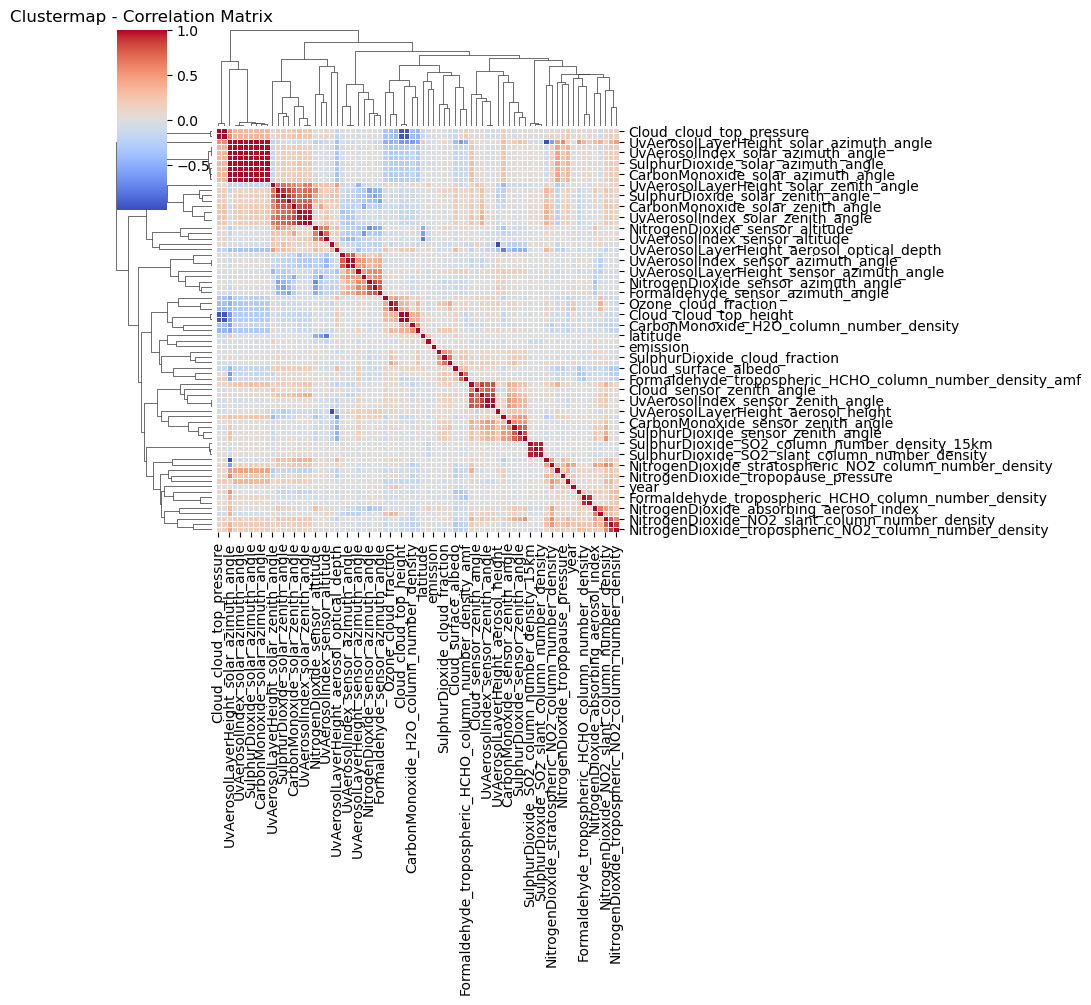

In [6]:
correlation_matrix = train.corr()
correlation_matrix.fillna(0, inplace=True)

plt.figure(figsize=(12, 10))
sns.clustermap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Clustermap - Correlation Matrix")
plt.show()

# Geospatial Clusters:

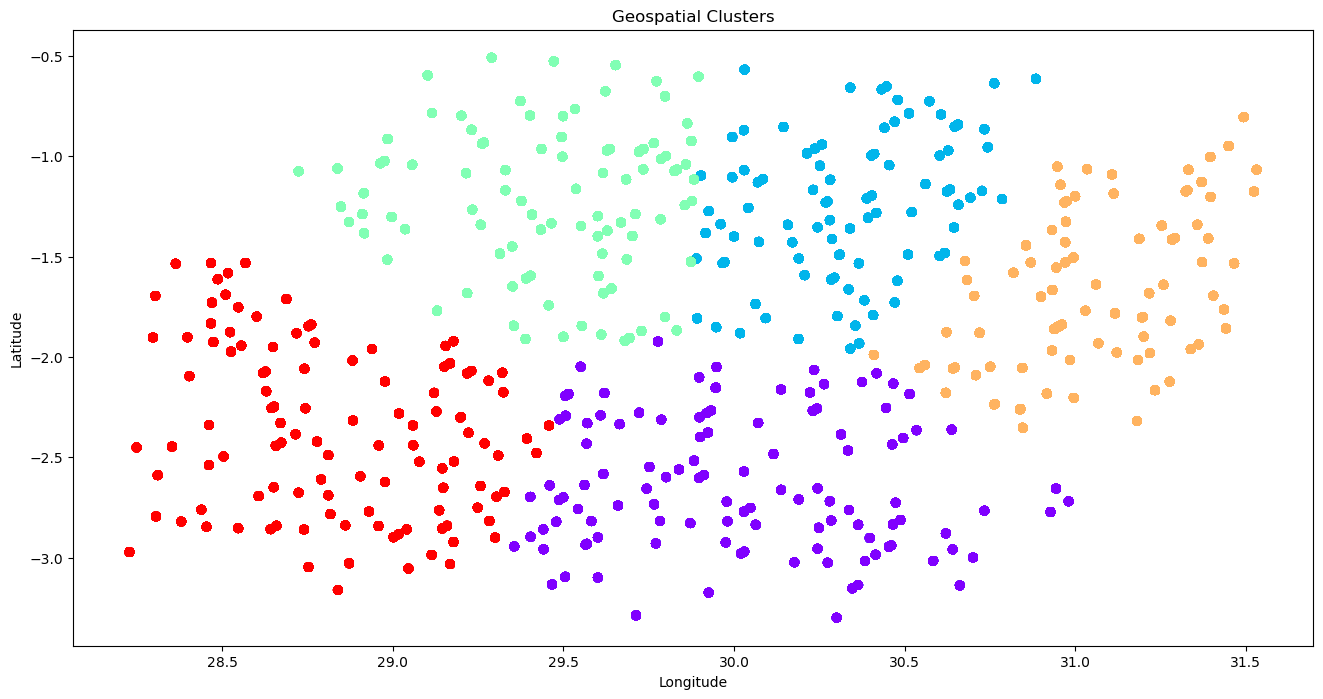

In [7]:
coordinates = train[['latitude', 'longitude']]
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train['cluster_label'] = kmeans.fit_predict(coordinates)

plt.figure(figsize=(16, 8))
plt.scatter(coordinates['longitude'], coordinates['latitude'], c=train['cluster_label'], cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Clusters')
plt.show()

# SO2 Density Plot and Distribution:

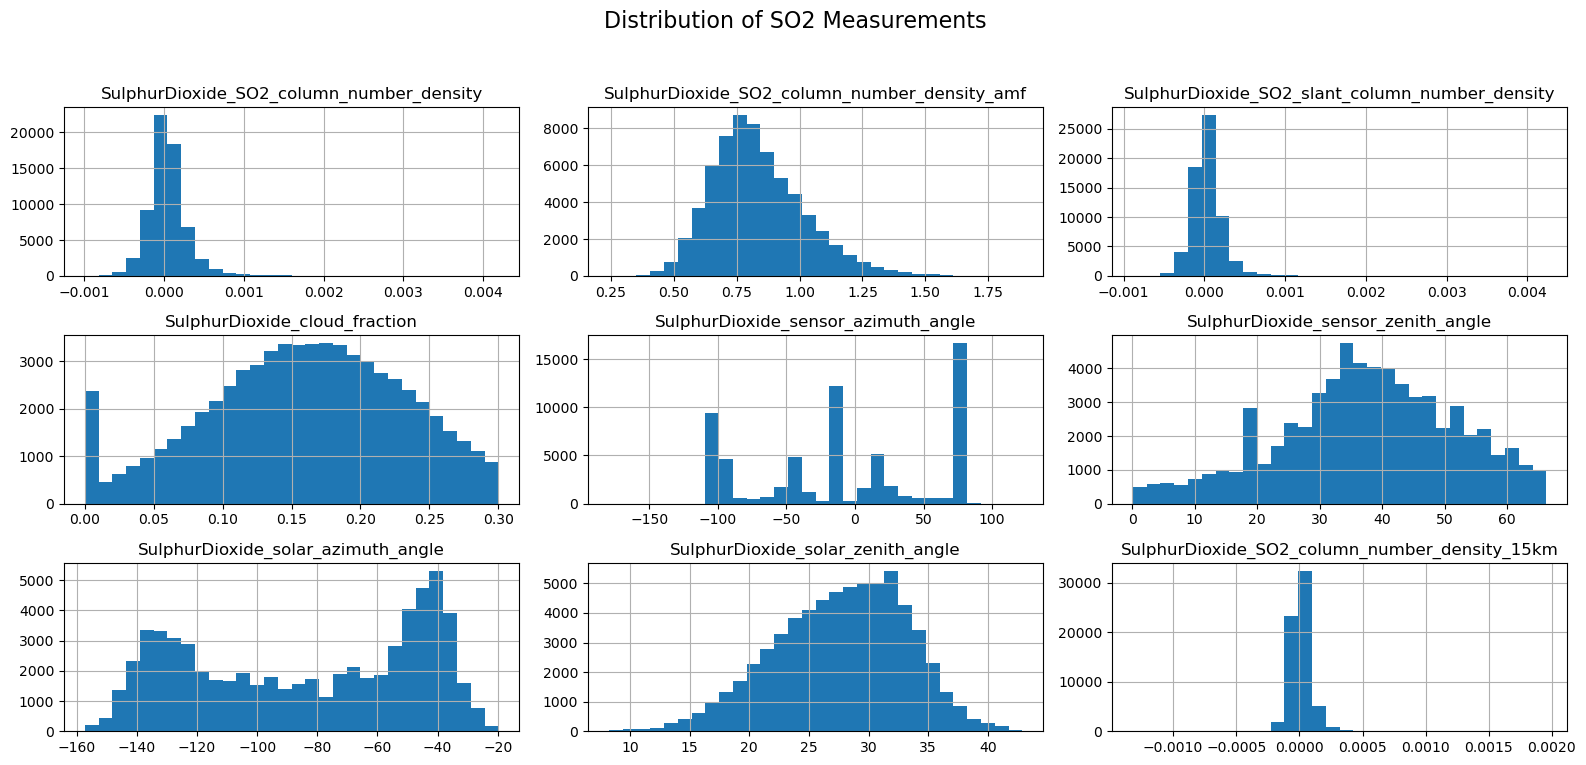

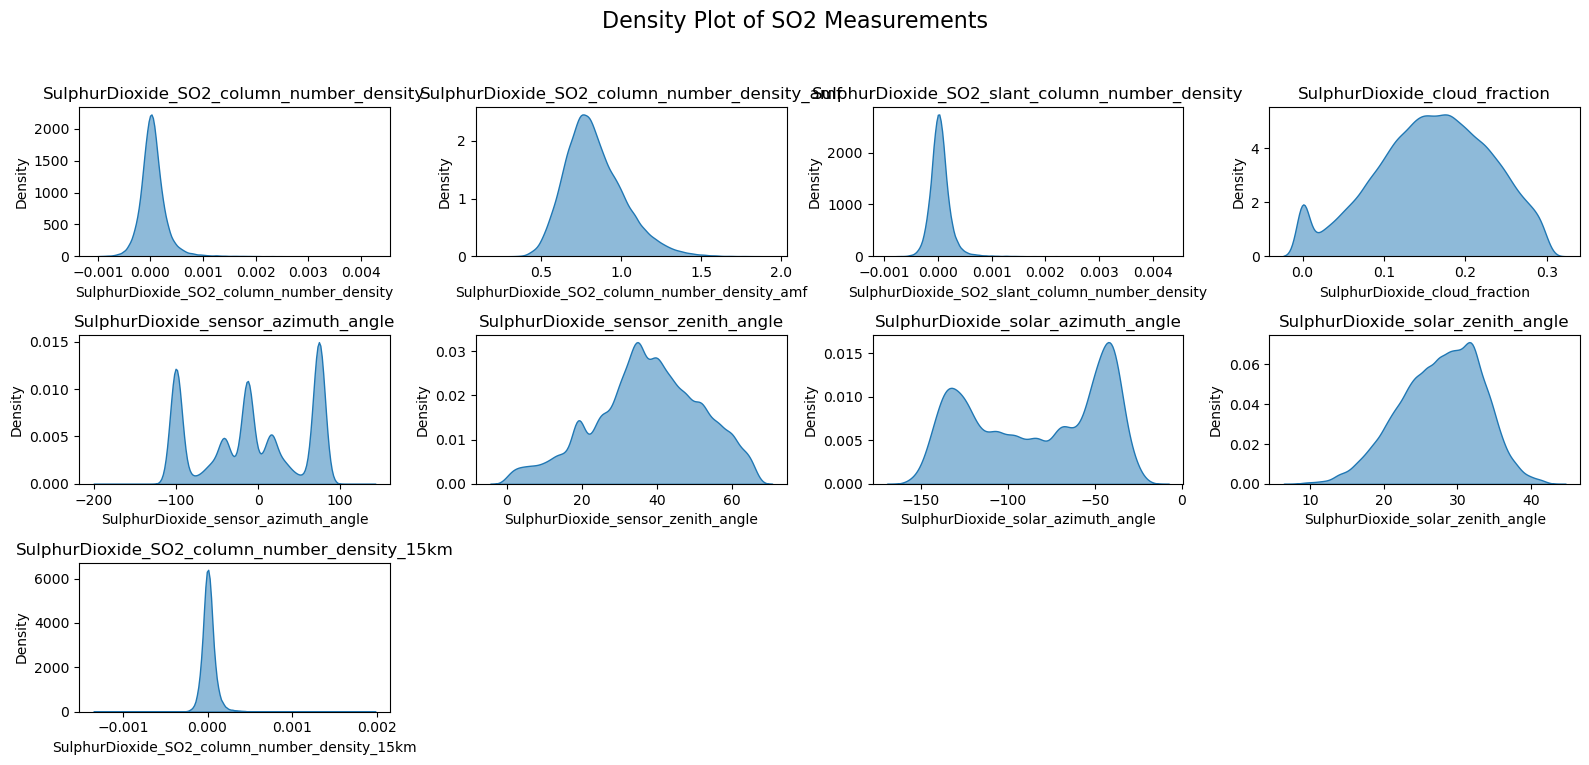

In [8]:
so_columns = ['SulphurDioxide_SO2_column_number_density',
               'SulphurDioxide_SO2_column_number_density_amf',
               'SulphurDioxide_SO2_slant_column_number_density',
               'SulphurDioxide_cloud_fraction',
               'SulphurDioxide_sensor_azimuth_angle',
               'SulphurDioxide_sensor_zenith_angle',
               'SulphurDioxide_solar_azimuth_angle',
               'SulphurDioxide_solar_zenith_angle',
               'SulphurDioxide_SO2_column_number_density_15km']


so_data = train[so_columns]

so_data.hist(bins=30, figsize=(16, 8))
plt.suptitle('Distribution of SO2 Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(16, 8))
num_columns = len(so_data.columns)
num_rows = (num_columns + 3) // 4  
for i, col in enumerate(so_data.columns):
    plt.subplot(num_rows, 4, i+1)
    sns.kdeplot(train[col], fill=True, alpha=0.5)
    plt.title(col)
plt.suptitle('Density Plot of SO2 Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# CO Density Plot and Distribution:

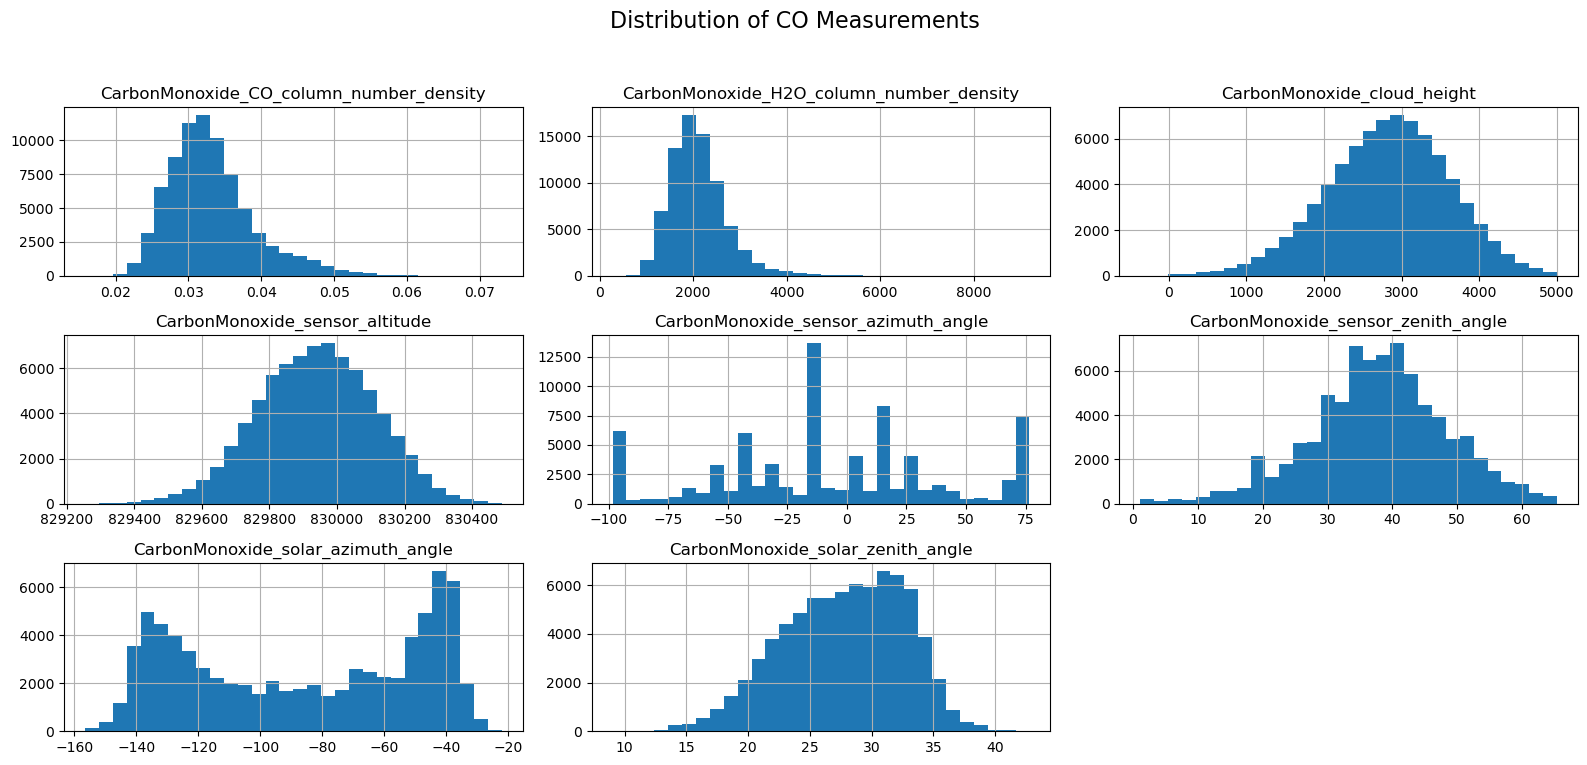

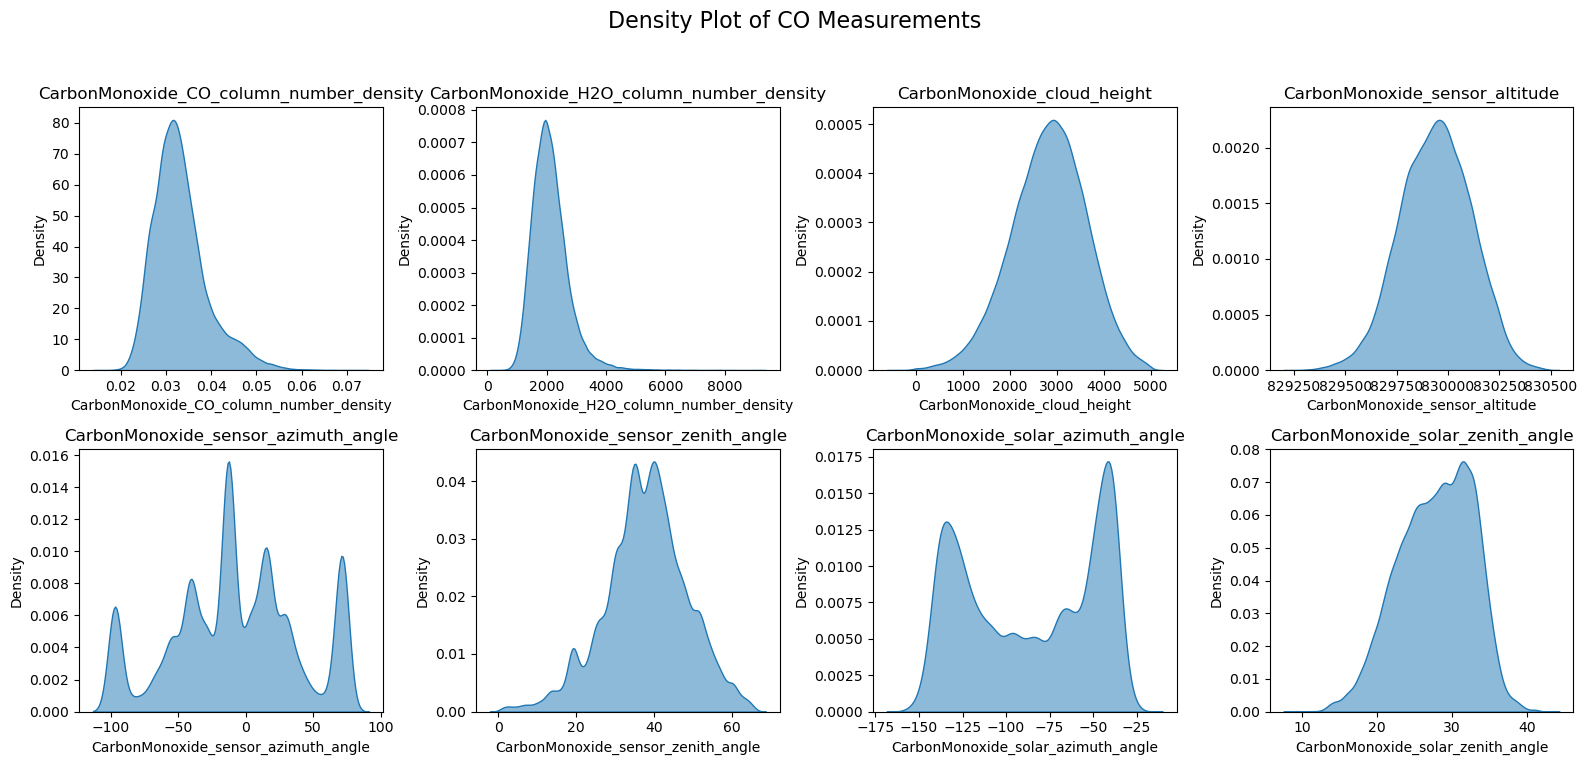

In [9]:
co_columns = ['CarbonMonoxide_CO_column_number_density',
              'CarbonMonoxide_H2O_column_number_density',
              'CarbonMonoxide_cloud_height',
              'CarbonMonoxide_sensor_altitude',
              'CarbonMonoxide_sensor_azimuth_angle',
              'CarbonMonoxide_sensor_zenith_angle',
              'CarbonMonoxide_solar_azimuth_angle',
              'CarbonMonoxide_solar_zenith_angle']


co_data = train[co_columns]

co_data.hist(bins=30, figsize=(16, 8))
plt.suptitle('Distribution of CO Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(16, 8))
for i, col in enumerate(co_data.columns):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(train[col], fill=True, alpha=0.5)
    plt.title(col)
plt.suptitle('Density Plot of CO Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Cloud Measurments Pair Plot:

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


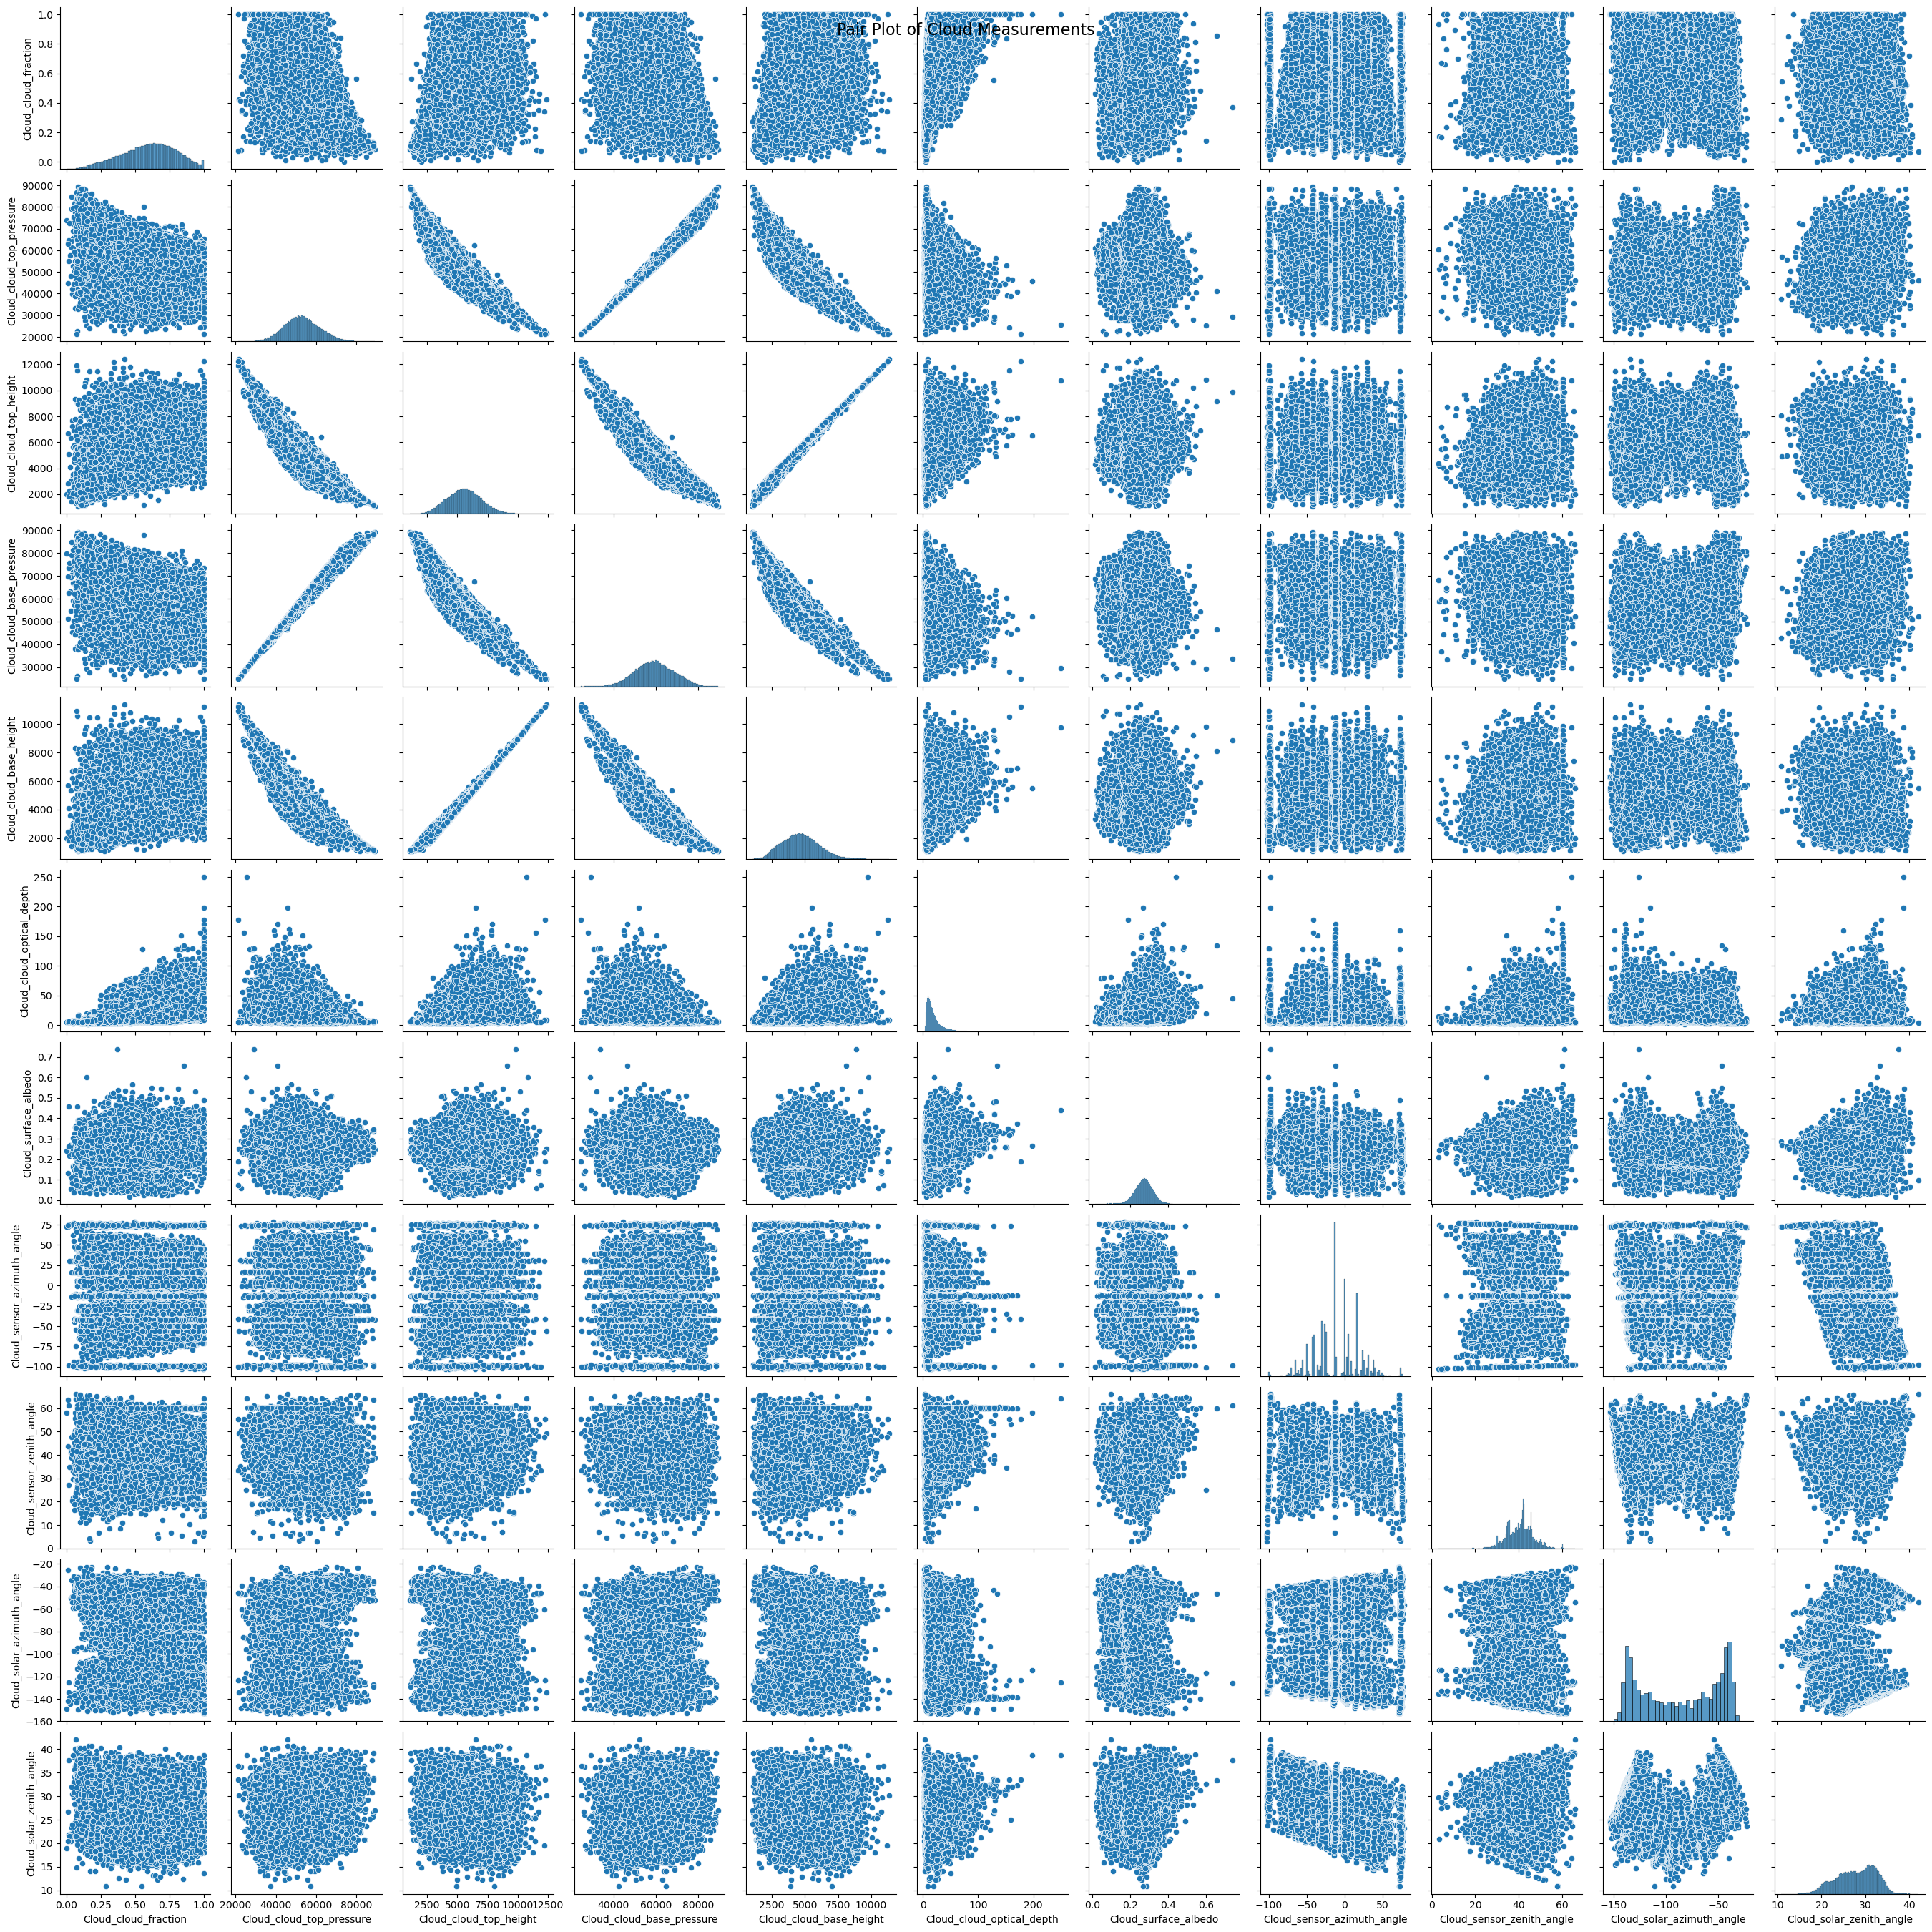

In [10]:
cloud_columns = ['Cloud_cloud_fraction',
                 'Cloud_cloud_top_pressure',
                 'Cloud_cloud_top_height',
                 'Cloud_cloud_base_pressure',
                 'Cloud_cloud_base_height',
                 'Cloud_cloud_optical_depth',
                 'Cloud_surface_albedo',
                 'Cloud_sensor_azimuth_angle',
                 'Cloud_sensor_zenith_angle',
                 'Cloud_solar_azimuth_angle',
                 'Cloud_solar_zenith_angle']

cloud_data = train[cloud_columns]

sns.pairplot(cloud_data)
plt.suptitle('Pair Plot of Cloud Measurements', fontsize=16)
plt.show()

# UV Aerosol Index Density Plot and Distribution:

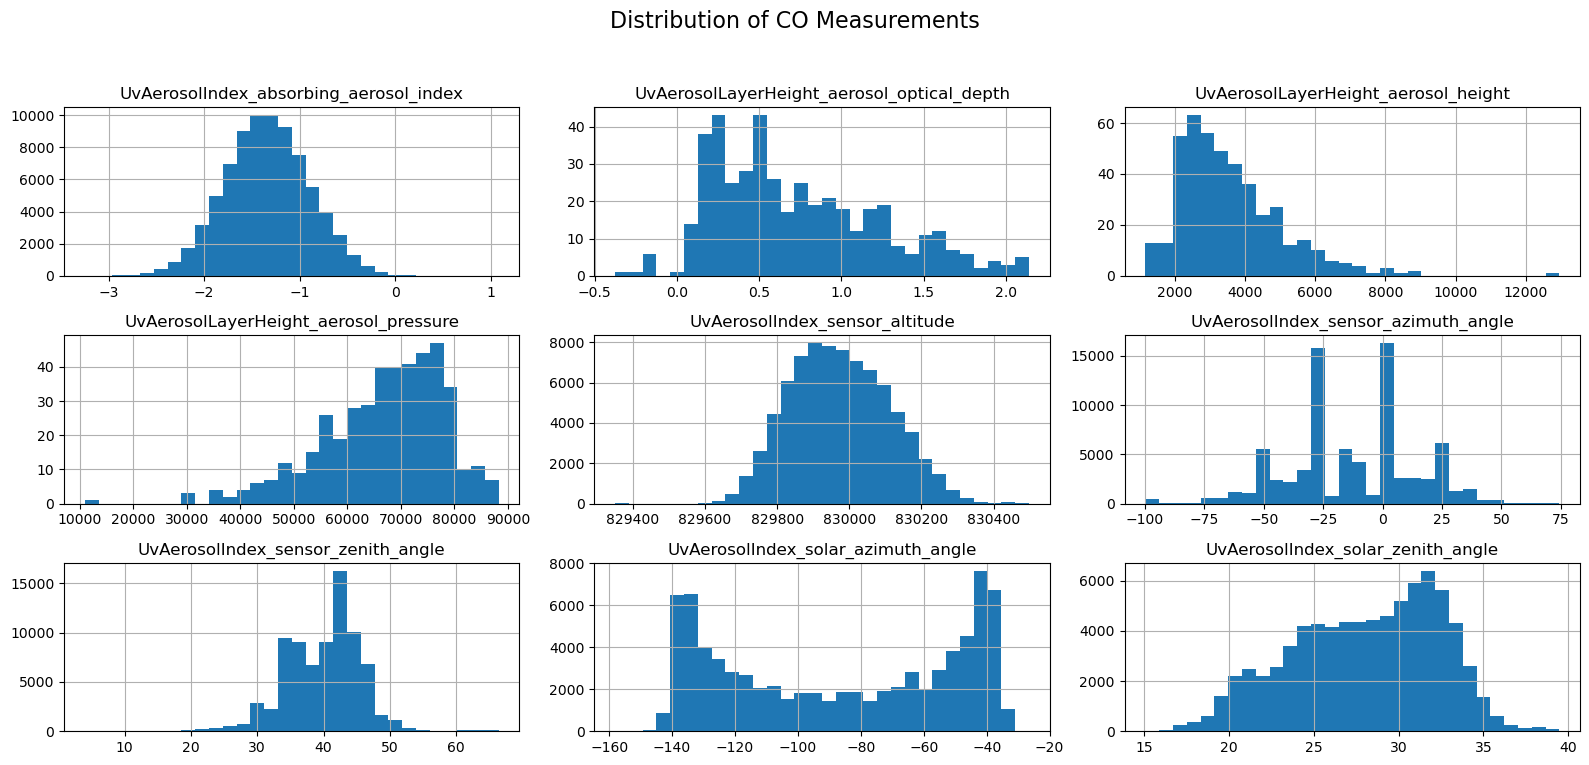

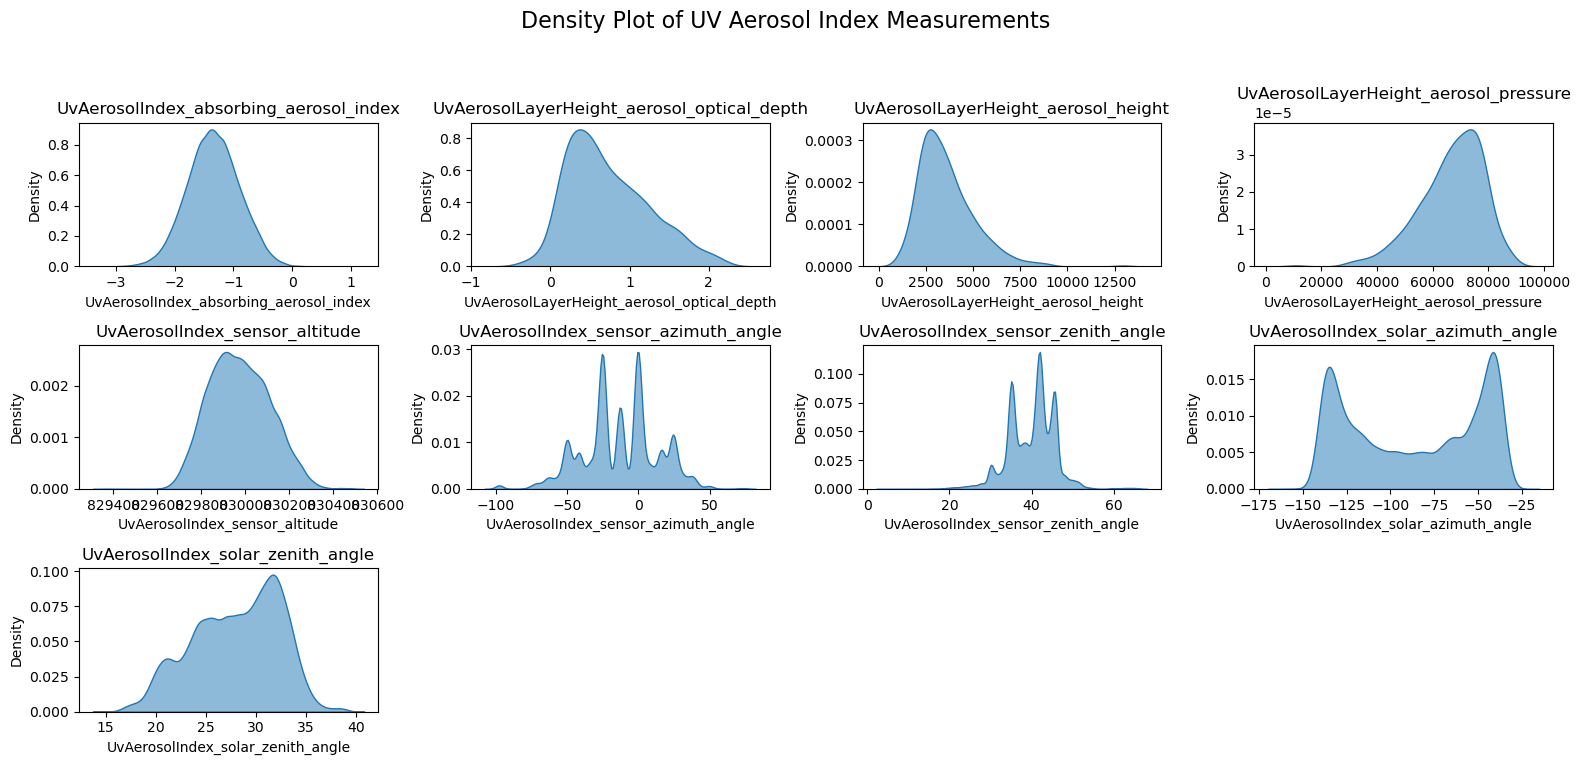

In [11]:
uvai_columns = ['UvAerosolIndex_absorbing_aerosol_index',
                'UvAerosolLayerHeight_aerosol_optical_depth',
                'UvAerosolLayerHeight_aerosol_height',
                'UvAerosolLayerHeight_aerosol_pressure',
                'UvAerosolIndex_sensor_altitude',
                'UvAerosolIndex_sensor_azimuth_angle',
                'UvAerosolIndex_sensor_zenith_angle',
                'UvAerosolIndex_solar_azimuth_angle',
                'UvAerosolIndex_solar_zenith_angle']

uvai_data = train[uvai_columns]

uvai_data.hist(bins=30, figsize=(16, 8))
plt.suptitle('Distribution of CO Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(16, 8))
num_columns = len(uvai_data.columns)
num_rows = (num_columns + 3) // 4
for i, col in enumerate(uvai_data.columns):
    plt.subplot(num_rows, 4, i+1)
    sns.kdeplot(train[col], fill=True, alpha=0.5)
    plt.title(col)
plt.suptitle('Density Plot of UV Aerosol Index Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# NO2 Density Plot and Distribution:

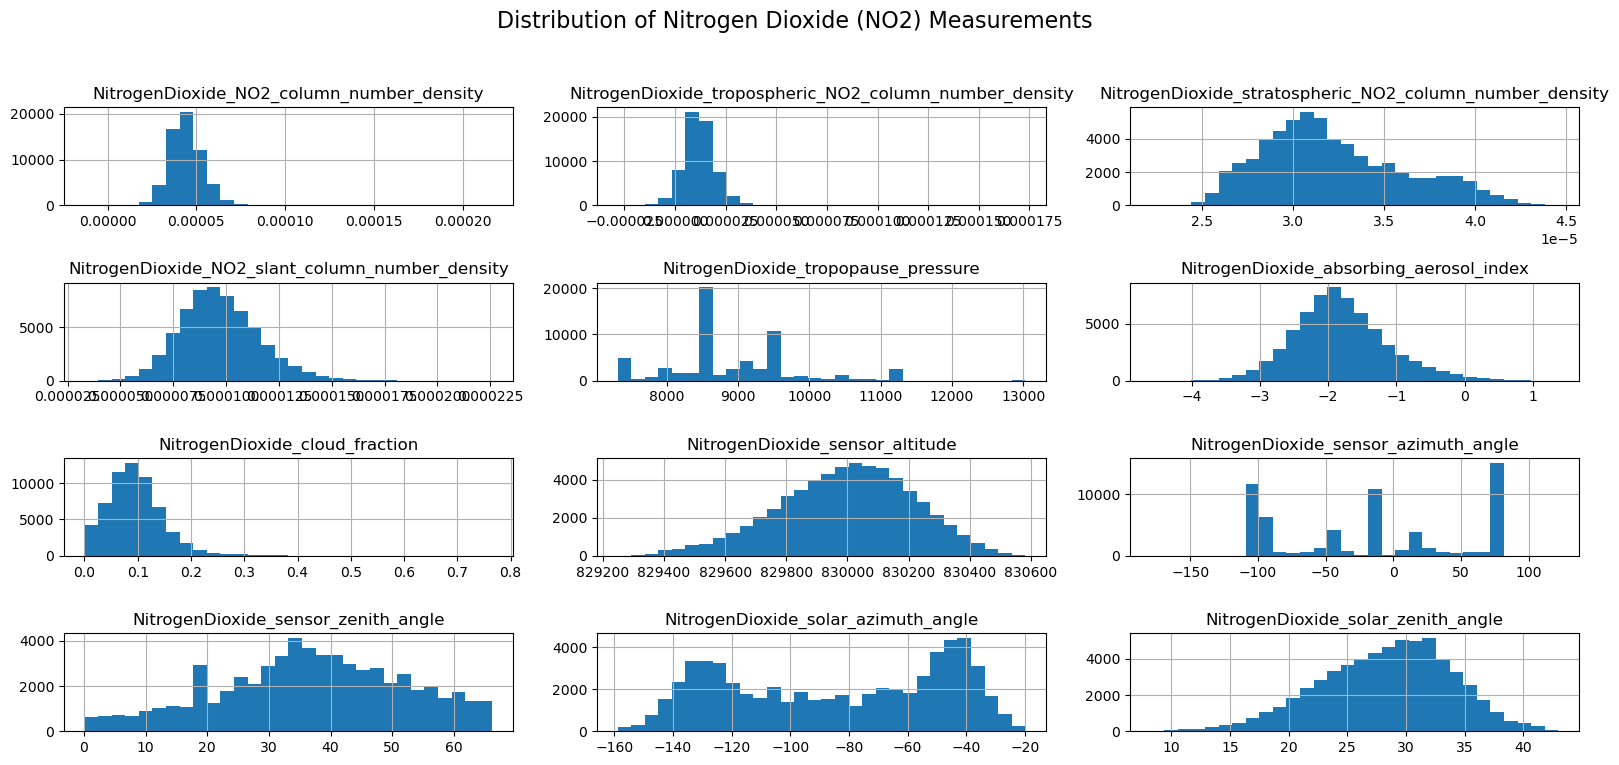

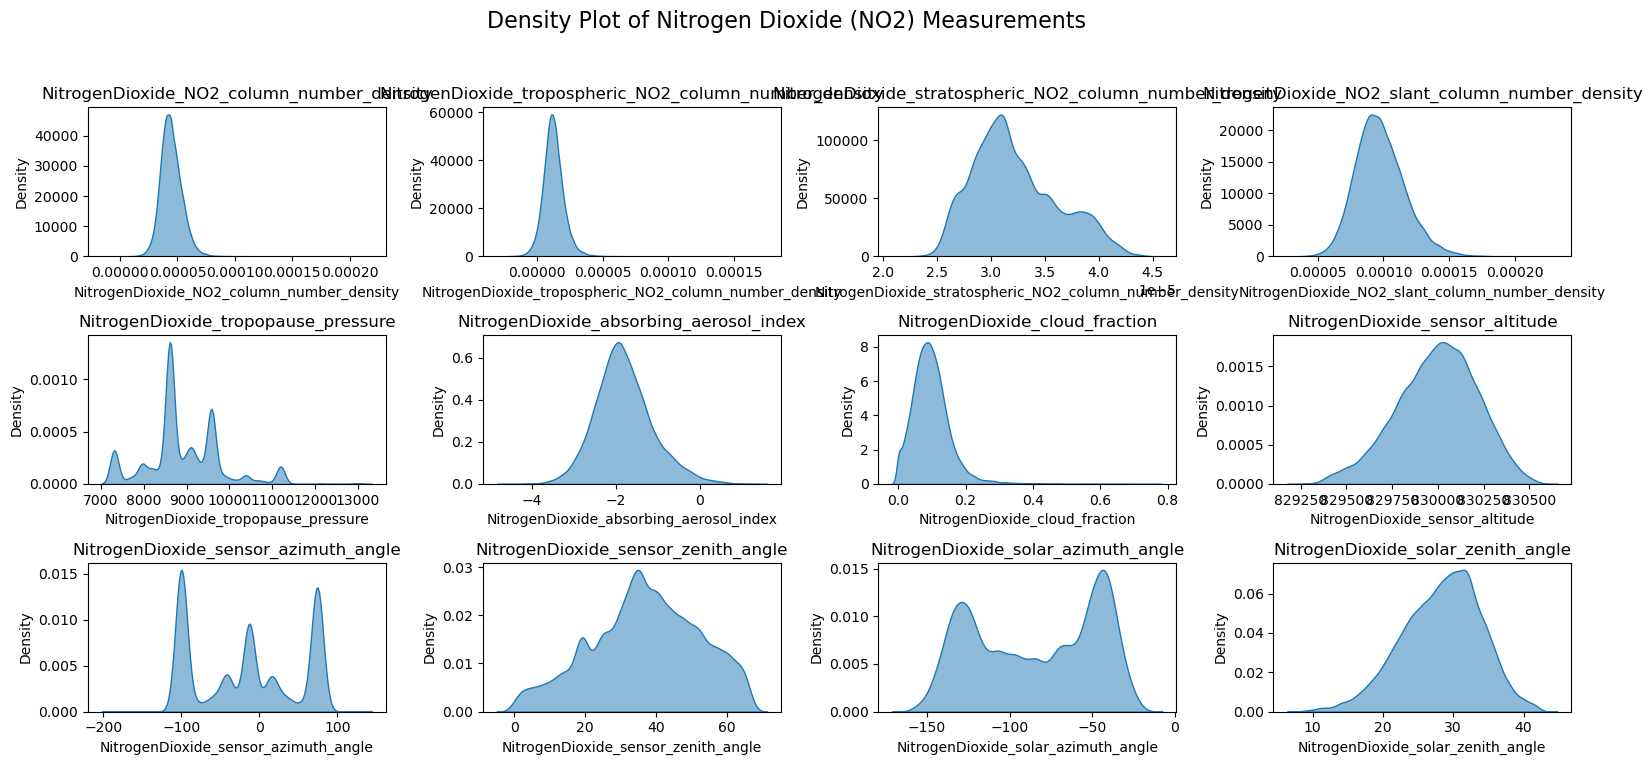

In [12]:
no2_columns = ['NitrogenDioxide_NO2_column_number_density',
               'NitrogenDioxide_tropospheric_NO2_column_number_density',
               'NitrogenDioxide_stratospheric_NO2_column_number_density',
               'NitrogenDioxide_NO2_slant_column_number_density',
               'NitrogenDioxide_tropopause_pressure',
               'NitrogenDioxide_absorbing_aerosol_index',
               'NitrogenDioxide_cloud_fraction',
               'NitrogenDioxide_sensor_altitude',
               'NitrogenDioxide_sensor_azimuth_angle',
               'NitrogenDioxide_sensor_zenith_angle',
               'NitrogenDioxide_solar_azimuth_angle',
               'NitrogenDioxide_solar_zenith_angle']

no2_data = train[no2_columns]

no2_data.hist(bins=30, figsize=(16, 8))
plt.suptitle('Distribution of Nitrogen Dioxide (NO2) Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(16, 8))
num_columns = len(no2_data.columns)
num_rows = (num_columns + 3) // 4
for i, col in enumerate(no2_data.columns):
    plt.subplot(num_rows, 4, i+1)
    sns.kdeplot(train[col], fill=True, alpha=0.5)
    plt.title(col)
plt.suptitle('Density Plot of Nitrogen Dioxide (NO2) Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Formaldehyde (HCHO) Density Plot and Distribution:

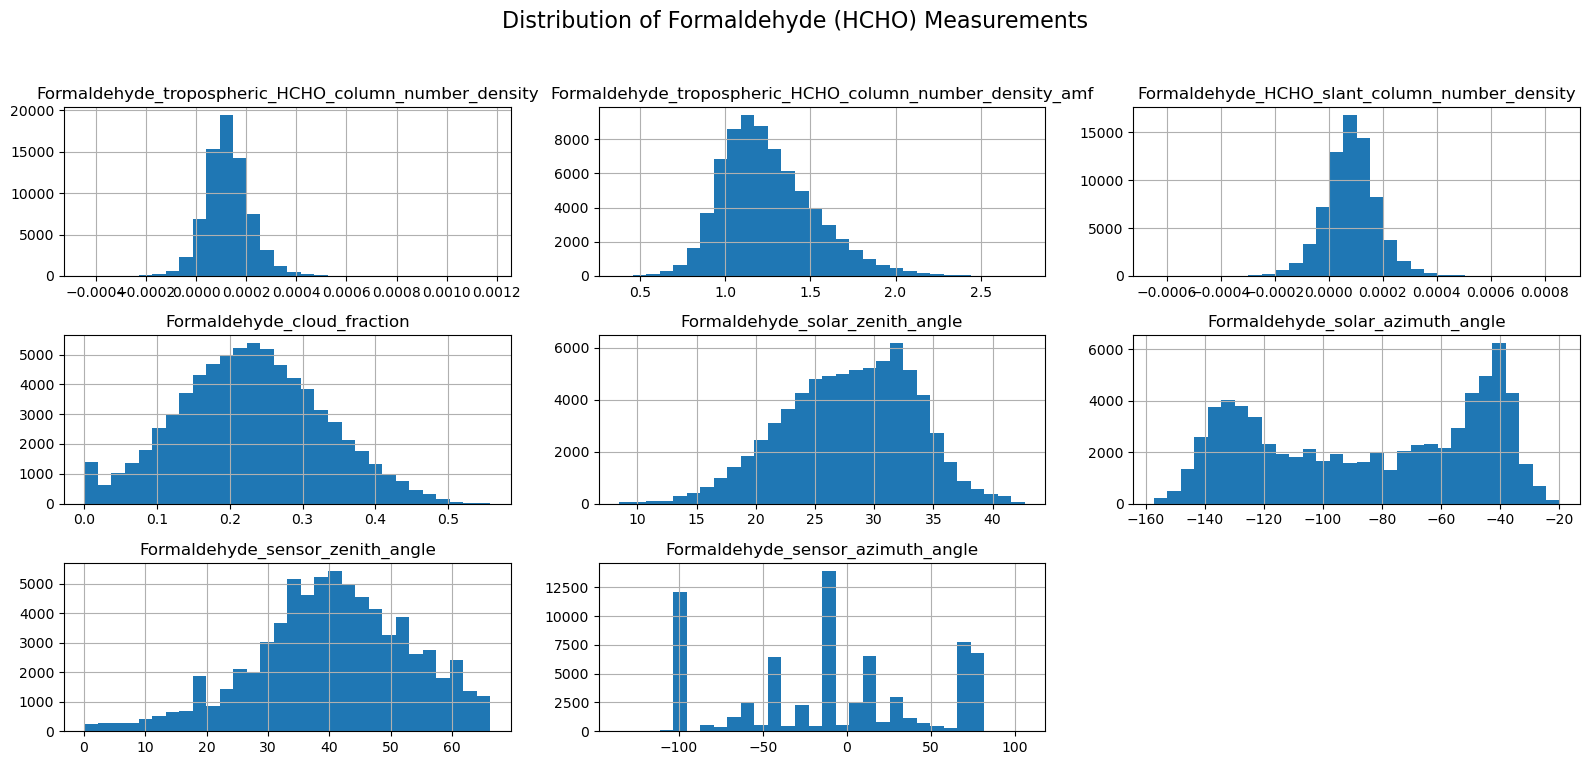

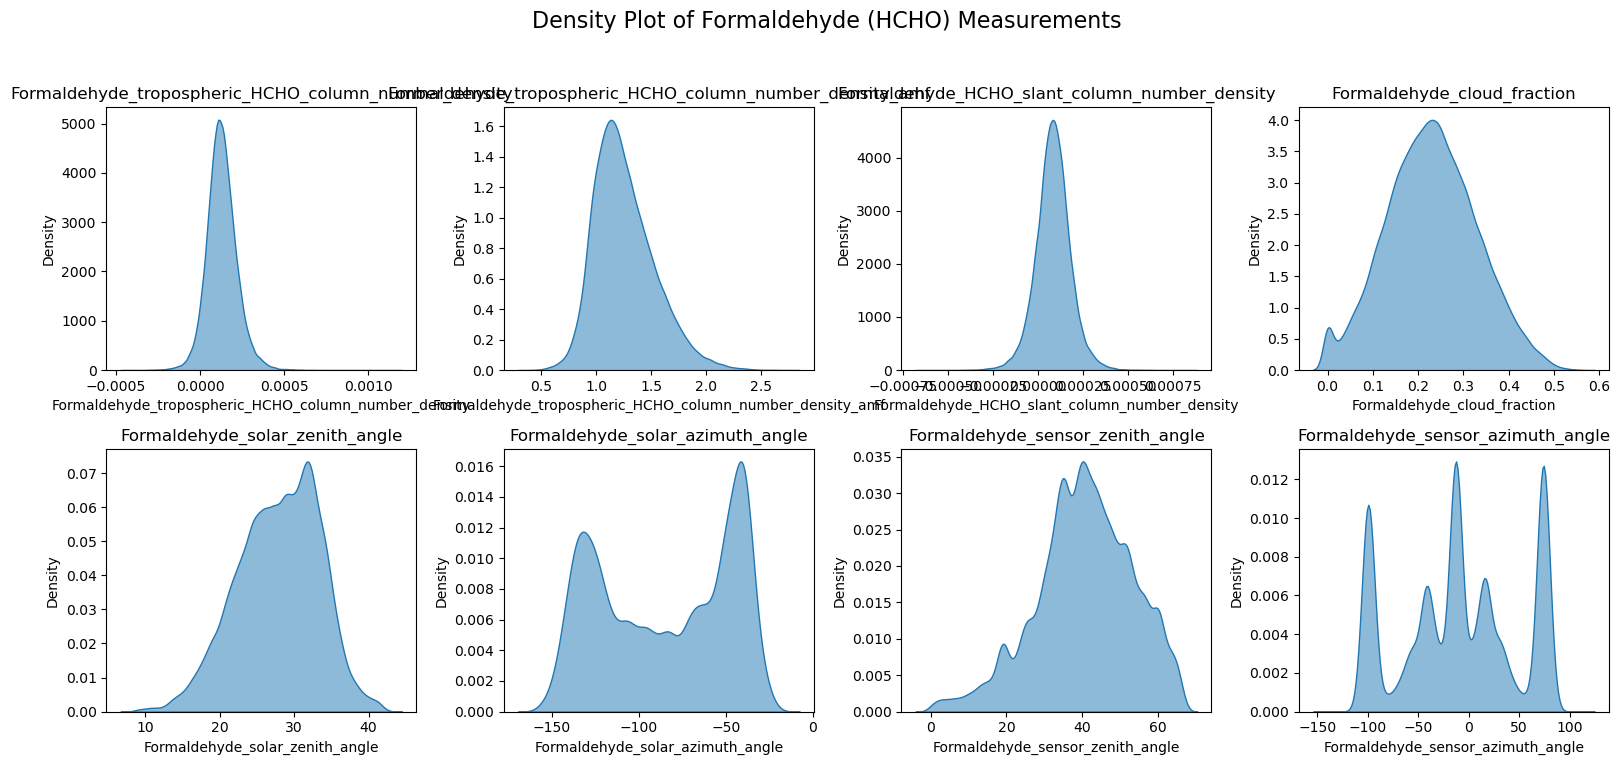

In [13]:
hcho_columns = ['Formaldehyde_tropospheric_HCHO_column_number_density',
                'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
                'Formaldehyde_HCHO_slant_column_number_density',
                'Formaldehyde_cloud_fraction',
                'Formaldehyde_solar_zenith_angle',
                'Formaldehyde_solar_azimuth_angle',
                'Formaldehyde_sensor_zenith_angle',
                'Formaldehyde_sensor_azimuth_angle']


hcho_data = train[hcho_columns]

hcho_data.hist(bins=30, figsize=(16, 8))
plt.suptitle('Distribution of Formaldehyde (HCHO) Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(16, 8))
num_columns = len(hcho_data.columns)
num_rows = (num_columns + 3) // 4
for i, col in enumerate(hcho_data.columns):
    plt.subplot(num_rows, 4, i+1)
    sns.kdeplot(train[col], fill=True, alpha=0.5)
    plt.title(col)
plt.suptitle('Density Plot of Formaldehyde (HCHO) Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Ozone (O3) Density Plot and Distribution:

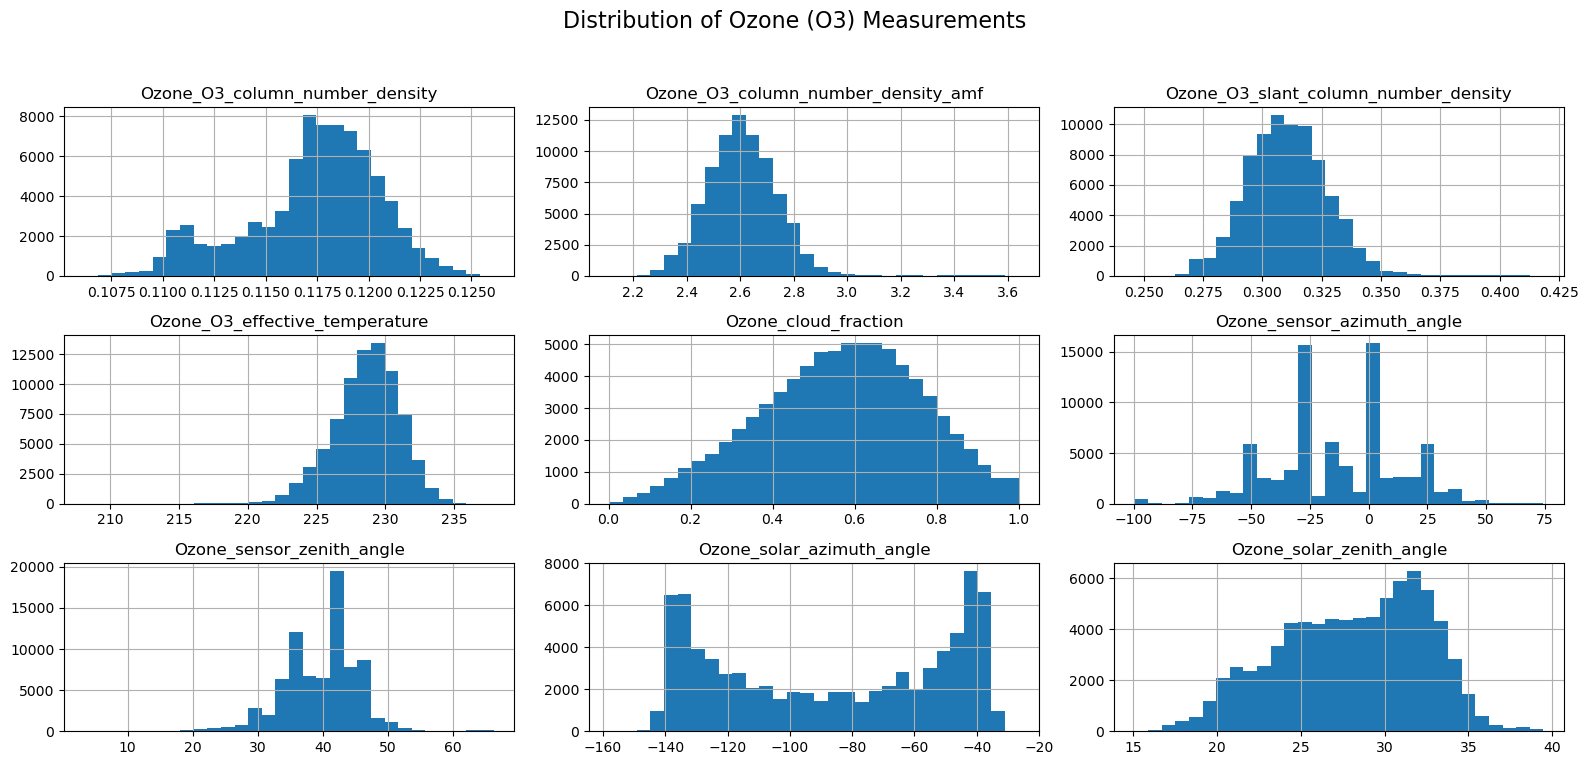

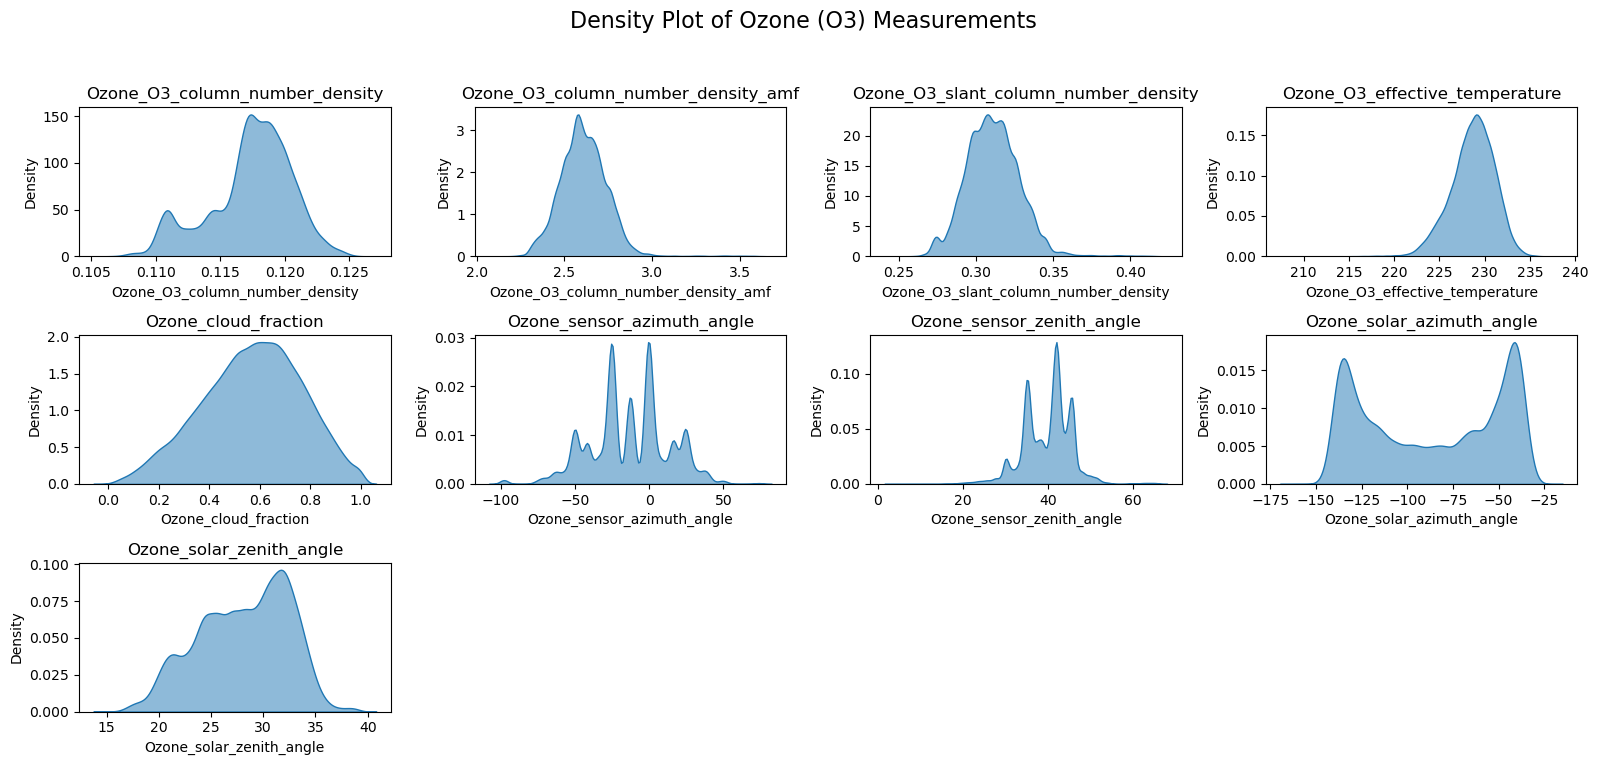

In [14]:
ozone_columns = ['Ozone_O3_column_number_density',
                 'Ozone_O3_column_number_density_amf',
                 'Ozone_O3_slant_column_number_density',
                 'Ozone_O3_effective_temperature',
                 'Ozone_cloud_fraction',
                 'Ozone_sensor_azimuth_angle',
                 'Ozone_sensor_zenith_angle',
                 'Ozone_solar_azimuth_angle',
                 'Ozone_solar_zenith_angle']

ozone_data = train[ozone_columns]

ozone_data.hist(bins=30, figsize=(16, 8))
plt.suptitle('Distribution of Ozone (O3) Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(16, 8))
num_columns = len(ozone_data.columns)
num_rows = (num_columns + 3) // 4
for i, col in enumerate(ozone_data.columns):
    plt.subplot(num_rows, 4, i+1)
    sns.kdeplot(train[col], fill=True, alpha=0.5)
    plt.title(col)
plt.suptitle('Density Plot of Ozone (O3) Measurements', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Geo visualization

In [15]:
train_coords = train.drop_duplicates(subset=['latitude', 'longitude']).copy()
test_coords = test.drop_duplicates(subset=['latitude', 'longitude']).copy()

train_coords.loc[:, 'set_type'] = 'train'
test_coords.loc[:, 'set_type'] = 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index=True)
geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(all_data[["latitude", "longitude", "set_type"]], geometry=geometry)

all_data_map = folium.Map(prefer_canvas=True, zoom_start=10)

train_color = "green"
test_color = "orange"

for index, row in geo_df.iterrows():
    coordinates = [row['latitude'], row['longitude']]
    popup_content = f"Coordinates: {coordinates}<br>Set: {row['set_type']}"
    

    folium.CircleMarker(
        location=coordinates,
        radius=4, 
        weight=2,
        popup=popup_content,
        color=train_color if row['set_type'] == "train" else test_color,
        fill=True,
        fill_opacity=0.7,
    ).add_to(all_data_map)

legend_html = """
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; padding: 10px; background-color: white; border: 1px solid grey;">
      <p><span style="background-color: green; border-radius: 50%; padding: 5px;"></span> Train Set</p>
      <p><span style="background-color: orange; border-radius: 50%; padding: 5px;"></span> Test Set</p>
    </div>
    """
all_data_map.get_root().html.add_child(folium.Element(legend_html))

all_data_map

# Weekly Carbon Emissions:

In [16]:
weekly_emissions = pd.DataFrame({
    'date': pd.date_range(start='2019-01-01', periods=156, freq='W'),
    'year': [2019]*52 + [2020]*52 + [2021]*52,
    'SulphurDioxide': [0.5]*52 + [0.4]*52 + [0.3]*52,
    'CarbonMonoxide': [1.2]*52 + [1.0]*52 + [0.8]*52,
    'NitrogenDioxide': [0.7]*52 + [0.6]*52 + [0.5]*52,
    'Formaldehyde': [0.3]*52 + [0.2]*52 + [0.1]*52
})

fig = go.Figure()

pollutant_groups = ['SulphurDioxide', 'CarbonMonoxide', 'NitrogenDioxide', 'Formaldehyde']
for pollutant in pollutant_groups:
    fig.add_trace(go.Scatter(x=weekly_emissions['date'], y=weekly_emissions[pollutant], mode='lines', name=pollutant))
fig.update_layout(
    title_text='Weekly Carbon Emissions by Year for Each Pollutant Group',
    xaxis=dict(
        title='Date',
        titlefont_size=16,
    ),
    yaxis=dict(
        title='Emission Value',
        titlefont_size=16,
    ),
    template='xgridoff'
)

fig.show()